In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle

from scipy import signal
from scipy.interpolate import interp1d
from scipy.optimize import minimize

from pathlib import Path
from src.data.file_utils import GetTV

In [3]:
def nearest_index(array, value):
    """Find the index of the nearest value in an array."""
    return (np.abs(array - value)).argmin()

def crop_time(times, data, start_time, end_time):
    """Crop the data to the specified time range."""
    if data.ndim == 1:
        data = data.reshape(1, -1)
    start_idx = nearest_index(times, start_time)
    end_idx = nearest_index(times, end_time)
    return times[start_idx:end_idx], data[:,start_idx:end_idx]

In [204]:
def dz_normalized(ze, zx, zs):
    return (ze - zs) / (zx - zs)

def dz_unnormalized(ze, zx, zs):
    return ze - zs

In [205]:
mdl_path = "../models/lr_coef.txt"  # Replace with your file path

with open(mdl_path, "r") as file:
    coef = file.readlines()

mdl_path = "../models/lr_intercept.txt"  # Replace with your file path

with open(mdl_path, "r") as file:
    inter = file.readlines()
    
coef_ = np.array([float(i) for i in coef])
inter_ = np.array([float(i) for i in inter])
r_coef_ = coef_[:len(coef_)//2]
z_coef_ = coef_[len(coef_)//2:]

In [206]:
shot_idx = 3

In [207]:
data_path = "../data/raw/tv_images/l-mode"
tv = GetTV(data_path)
files = tv.list_files()
files = sorted(files, key=lambda x: int(Path(x).stem.split('_')[-1]))
radii = tv.load(files[shot_idx], 'radii')[0]
elevation = tv.load(files[shot_idx], 'elevation')[0]
vid_shape = tv.load(files[shot_idx], 'vid')[0].shape
vid_times = tv.load(files[shot_idx], 'vid_times')

In [208]:
frames = tv.load(files[shot_idx], 'vid')
print("Extracting video:", files[shot_idx].stem)
frames_reshape = frames.reshape(len(frames), -1)

Extracting video: emission_structure_pu_cam240perp_190114


In [209]:
print(frames_reshape.shape)

(420, 172800)


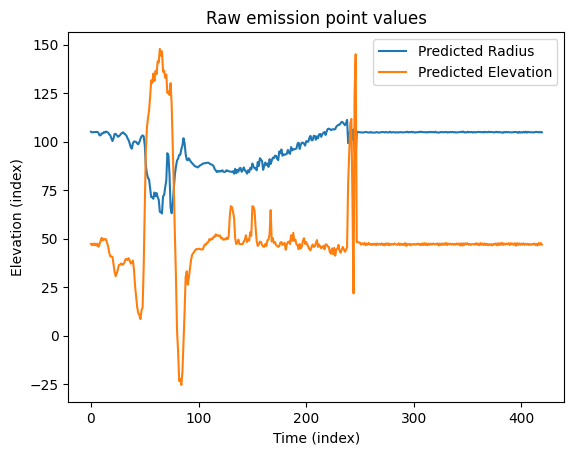

In [210]:
# example index 1
pred_r = np.dot(frames_reshape, r_coef_) + inter_[0] # left half
pred_z = np.dot(frames_reshape, z_coef_) + inter_[1] # right half
plt.plot(pred_r, label = "Predicted Radius")
plt.plot(pred_z, label = "Predicted Elevation")
plt.ylabel("Elevation (index)")
plt.xlabel("Time (index)")
plt.legend()
plt.title("Raw emission point values")
plt.show()

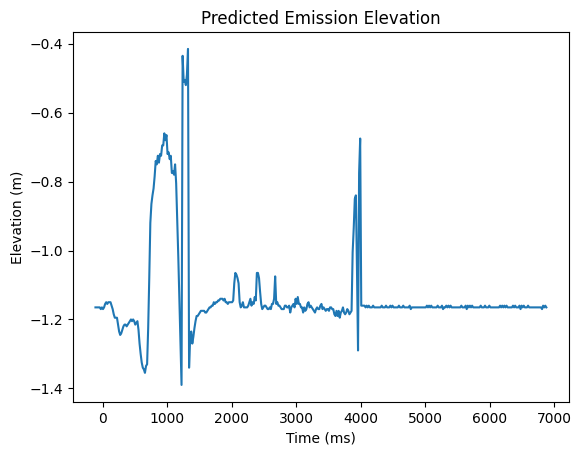

In [211]:
real_pred_r = radii[np.round(pred_r).astype(int)]
real_pred_z = elevation[np.round(pred_z).astype(int)]
plt.ylabel("Elevation (m)")
plt.xlabel("Time (ms)")
plt.plot(vid_times,real_pred_z)
plt.title("Predicted Emission Elevation")
plt.show()

In [212]:
pkl_path = '../data/external/toksearch/detach.pkl'

with open(pkl_path, 'rb') as file:
    points = pickle.load(file)
    
point_keys = list(points.keys())
shot = points[point_keys[shot_idx]]['vars']
times = points[point_keys[shot_idx]]['time']
times_transp = np.transpose(times)
shot_transp = np.transpose(shot)
print(point_keys)
print("Extracting pkl for shot: ", point_keys[shot_idx])

[190109, 190110, 190113, 190114, 190115, 190116]
Extracting pkl for shot:  190114


In [213]:
gas_types = ['Ar_tot', 'D_tot', 'H_tot', 'He_tot', 'N_tot', 'Ne_tot']
gas_valves = ['gasA', 'gasB', 'gasC', 'gas_sql']

In [214]:
h5_path = '../data/external/toksearch/detach.h5'

with h5py.File(h5_path, 'r') as file:
    keys = list(file.keys())
    print(keys)

['190109', '190110', '190113', '190114', '190115', '190116', 'spatial_coordinates', 'times']


In [215]:
with h5py.File(h5_path, 'r') as file:
    shot = file[keys[shot_idx]]
    print("Extracting h5 for shot: ", keys[shot_idx])
    if 't_ip_flat_sql' in shot:
        t_ip_flat = shot['t_ip_flat_sql'][()]
        print('t_ip_flat:', t_ip_flat)
    else:
        print("t_ip_flat_sql not found in h5 file.")
    if 'ip_flat_duration_sql' in shot:
        ip_flat_duration = shot['ip_flat_duration_sql'][()]
        print('ip_flat_duration:', ip_flat_duration)
    else:
        print("ip_flat_duration_sql not found in h5 file.")

Extracting h5 for shot:  190114
t_ip_flat: 1006.47998046875
ip_flat_duration: 2815.800048828125


In [397]:
# crop_times, crop_shot = crop_time(times_transp, shot_transp, t_ip_flat, ip_flat_duration)
# crop_times_vid, crop_pred_z = crop_time(vid_times, np.expand_dims(real_pred_z, axis=0), t_ip_flat, ip_flat_duration)
manual_crop_start = 2200
manual_crop_end = 2500
crop_times, crop_shot = crop_time(times_transp, shot_transp, manual_crop_start, manual_crop_end)
crop_times_vid, crop_pred_z = crop_time(vid_times, np.expand_dims(real_pred_z, axis=0), manual_crop_start, manual_crop_end)
zx = crop_shot[1] / 1e2
zs = crop_shot[3] / 1e2
ze = crop_pred_z[0]

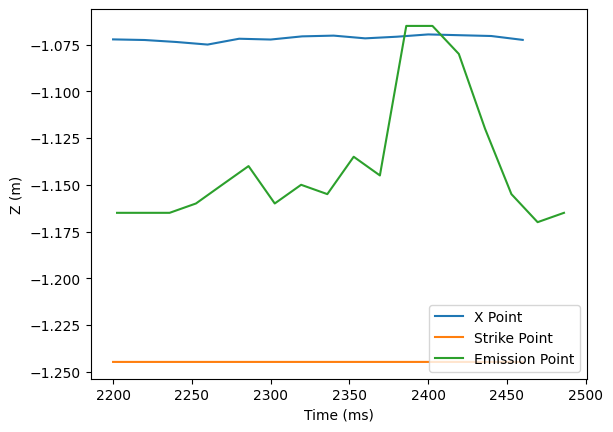

In [398]:
# plt.plot(crop_times, crop_shot[0], label="rx")
plt.plot(crop_times, zx, label="X Point")
# plt.plot(crop_times, crop_shot[2], label="rs")
plt.plot(crop_times, zs, label="Strike Point")
plt.plot(crop_times_vid, ze, label="Emission Point")
plt.xlabel("Time (ms)")
plt.ylabel("Z (m)")
plt.legend()
plt.show()

In [399]:
interp_points = 100
times_interp = np.linspace(crop_times[0], crop_times[-1], interp_points)

In [400]:
interp_kind = 'linear'
interpolator = interp1d(crop_times_vid, ze, kind=interp_kind,
                        fill_value='extrapolate')
ze_interp = interpolator(times_interp)

interpolator = interp1d(crop_times, zx, kind=interp_kind,
                        fill_value='extrapolate')
zx_interp = interpolator(times_interp)
interpolator = interp1d(crop_times, zs, kind=interp_kind,
                        fill_value='extrapolate')
zs_interp = interpolator(times_interp)

In [401]:
dz_norm_interp = dz_normalized(ze_interp, zx_interp, zs_interp)
dz_unnorm_interp = dz_unnormalized(ze_interp, zx_interp, zs_interp)

Text(0.5, 1.0, 'ze')

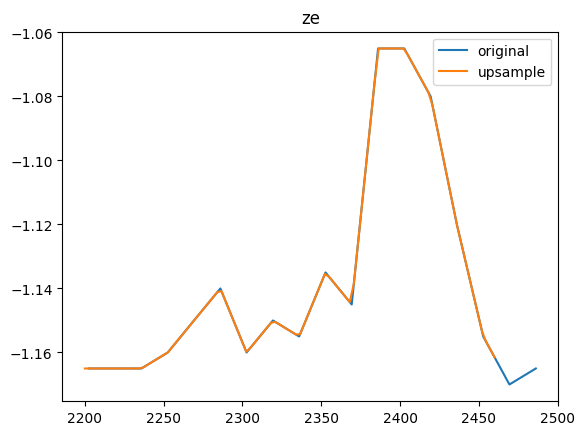

In [402]:
plt.plot(crop_times_vid, ze, label='original')
plt.plot(times_interp, ze_interp, label='upsample')
plt.legend()
plt.title("ze")

Text(0.5, 1.0, 'zx')

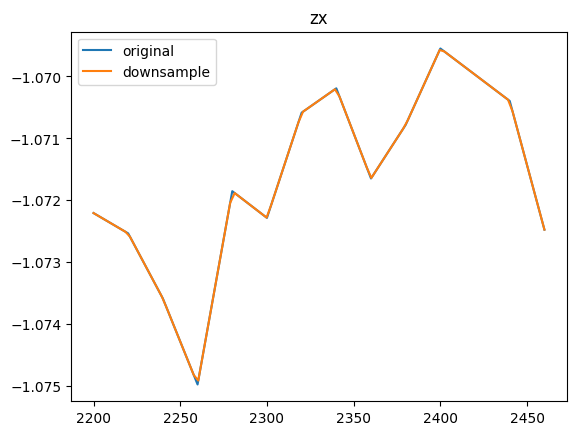

In [403]:
plt.plot(crop_times, zx, label='original')
plt.plot(times_interp, zx_interp, label='downsample')
plt.legend()
plt.title("zx")

Text(0.5, 1.0, 'zs')

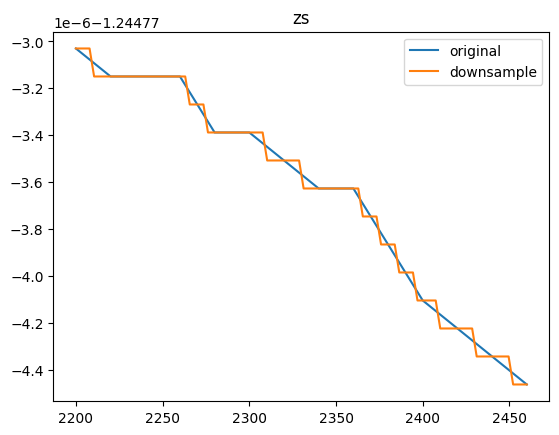

In [404]:
plt.plot(crop_times, zs, label='original')
plt.plot(times_interp, zs_interp, label='downsample')
plt.legend()
plt.title("zs")

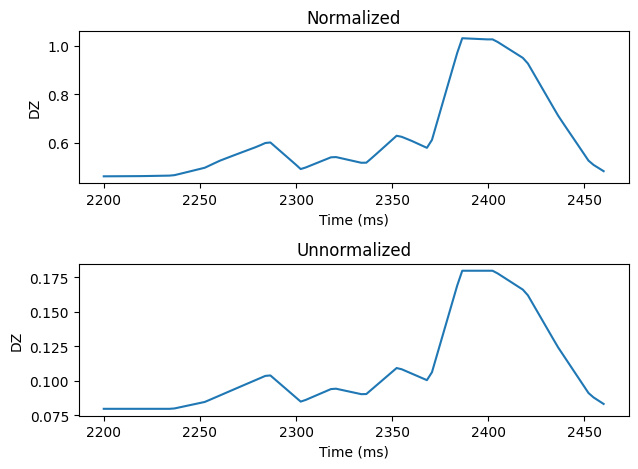

In [405]:
plt.subplot(2, 1, 1)
plt.plot(times_interp, dz_norm_interp)
plt.xlabel("Time (ms)")
plt.ylabel("DZ")
plt.title("Normalized")
plt.subplot(2, 1, 2)
plt.plot(times_interp, dz_unnorm_interp)
plt.xlabel("Time (ms)")
plt.ylabel("DZ")
plt.title("Unnormalized")
plt.tight_layout()
plt.show()

In [406]:
with h5py.File(h5_path, 'r') as file:
    D_tot = file[keys[shot_idx]]['D_tot'][:]
    Ar_tot = file[keys[shot_idx]]['Ar_tot'][:]
    H_tot = file[keys[shot_idx]]['H_tot'][:]
    He_tot = file[keys[shot_idx]]['He_tot'][:]
    N_tot = file[keys[shot_idx]]['N_tot'][:]
    Ne_tot = file[keys[shot_idx]]['Ne_tot'][:]
    h5_times = file['times'][:]

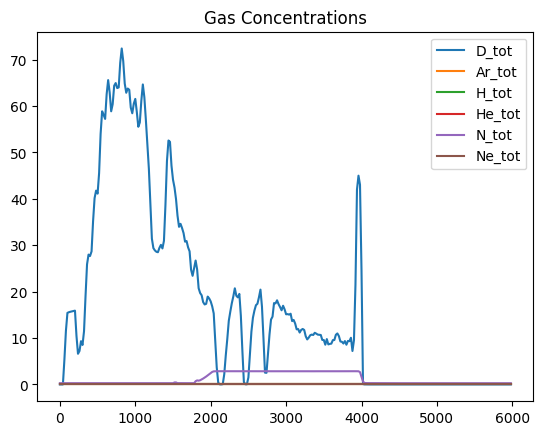

In [407]:
plt.plot(h5_times, D_tot, label = "D_tot")
plt.plot(h5_times, Ar_tot, label = "Ar_tot")
plt.plot(h5_times, H_tot, label = "H_tot")
plt.plot(h5_times, He_tot, label = "He_tot")
plt.plot(h5_times, N_tot, label = "N_tot")
plt.plot(h5_times, Ne_tot, label = "Ne_tot")
plt.legend()
plt.title("Gas Concentrations")
plt.show()

In [408]:
crop_h5_times, crop_D_tot = crop_time(h5_times, D_tot, manual_crop_start, manual_crop_end)
crop_D_tot = crop_D_tot[0]
interpolator = interp1d(crop_h5_times, crop_D_tot, kind=interp_kind,
                        fill_value='extrapolate')
D_interp = interpolator(times_interp)

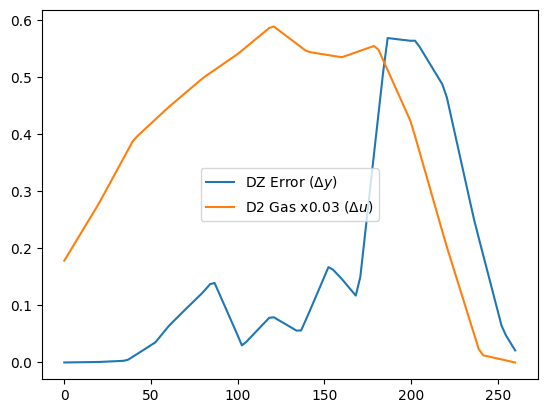

In [409]:
t = times_interp - times_interp[0]
u = D_interp - min(D_interp)
y = dz_norm_interp - min(dz_norm_interp)

plt.plot(t, y, label = "DZ Error ($\Delta y$)")
plt.plot(t, u/35, label = "D2 Gas x0.03 ($\Delta u$)")
plt.legend()
plt.show()

In [410]:
def fopdt_model(t, K, tau, L, u):
    idx_valid = np.where(t - L > 0)
    y = np.zeros_like(t)
    y[idx_valid] = K * (1 - np.exp(-(t[idx_valid] - L) / tau)) * u[idx_valid]
    return y

def cost_function(params, t, u, y):
    K, tau, L = params
    y_model = fopdt_model(t, K, tau, L, u)
    return np.sum((y - y_model) ** 2)

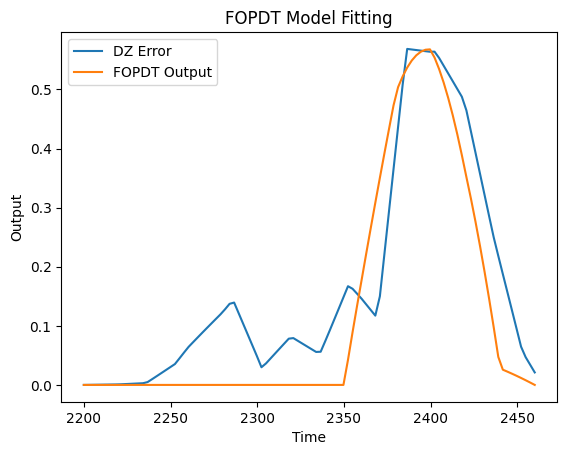

In [411]:
K_temp = 0.09799896453693978
tau_temp = 100
L_temp = 149.99823483977286

t = times_interp - times_interp[0]
u = D_interp - min(D_interp)
y = dz_norm_interp - min(dz_norm_interp)

y_model = fopdt_model(t, K_temp, tau_temp, L_temp, u)

plt.figure()
plt.plot(times_interp, y, label='DZ Error')
plt.plot(times_interp, y_model, label='FOPDT Output')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.title('FOPDT Model Fitting')
plt.show()

Optimal parameters: K = 0.09799896453693978, tau = 100.0, L = 149.99823483977286


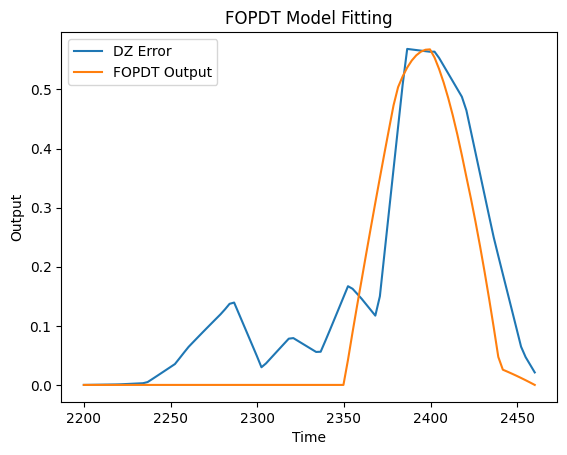

In [412]:
t = times_interp - times_interp[0]
u = D_interp - min(D_interp)
y = dz_norm_interp - min(dz_norm_interp)

# Initial guess for parameters
initial_guess = [1/10, 100, 150]

# Perform the optimization
result = minimize(cost_function, initial_guess, args=(t, u, y), bounds=[(0, None), (0, None), (0, None)])

# Extract the optimal parameters
K_opt, tau_opt, L_opt = result.x

# Print the results
print(f"Optimal parameters: K = {K_opt}, tau = {tau_opt}, L = {L_opt}")

# Plot the results
y_opt = fopdt_model(t, K_opt, tau_opt, L_opt, u)

plt.figure()
plt.plot(times_interp, y, label='DZ Error')
plt.plot(times_interp, y_opt, label='FOPDT Output')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.title('FOPDT Model Fitting')
plt.show()


In [111]:
Cp = 0.25
Ci = 2.67
Cd = 0.35

Gp = Cp*1/K_opt*tau_opt/L_opt
Ti = Ci*L_opt
Td = Cd*L_opt